In [1]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
df_train = pd.read_csv("Train.csv")
df_test = pd.read_csv("Test.csv")
sample_submission = pd.read_csv("SampleSubmission.csv")

In [3]:
new_submission = pd.DataFrame()
new_submission["uniqueid"] = df_test["uniqueid"].map(str) + " x " + df_test["country"].map(str)

In [4]:
df_train

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23519,Uganda,2018,uniqueid_2113,No,Rural,Yes,4,48,Female,Head of Household,Divorced/Seperated,No formal education,Other Income
23520,Uganda,2018,uniqueid_2114,No,Rural,Yes,2,27,Female,Head of Household,Single/Never Married,Secondary education,Other Income
23521,Uganda,2018,uniqueid_2115,No,Rural,Yes,5,27,Female,Parent,Widowed,Primary education,Other Income
23522,Uganda,2018,uniqueid_2116,No,Urban,Yes,7,30,Female,Parent,Divorced/Seperated,Secondary education,Self employed


In [5]:
df_train["country"].value_counts()

Rwanda      8735
Tanzania    6620
Kenya       6068
Uganda      2101
Name: country, dtype: int64

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


In [7]:
cat_col = []
num_col = []
for i in df_train:
    if df_train[i].dtypes == 'object':
        cat_col.append(i)
    else:
        num_col.append(i)

In [8]:
print("The categorical columns are: ", "\n", cat_col)
print("\n")
print("The numerical columns are: ", num_col)

The categorical columns are:  
 ['country', 'uniqueid', 'bank_account', 'location_type', 'cellphone_access', 'gender_of_respondent', 'relationship_with_head', 'marital_status', 'education_level', 'job_type']


The numerical columns are:  ['year', 'household_size', 'age_of_respondent']


In [9]:
print("Relationship: ", "\n", df_train["relationship_with_head"].value_counts())
print("\n")
print("Education: ", "\n", df_train["education_level"].value_counts())
print("\n")
print("Job: ", "\n", df_train["job_type"].value_counts())
print("\n")
print("Marital status: ", "\n", df_train["marital_status"].value_counts())

Relationship:  
 Head of Household      12831
Spouse                  6520
Child                   2229
Parent                  1086
Other relative           668
Other non-relatives      190
Name: relationship_with_head, dtype: int64


Education:  
 Primary education                  12791
No formal education                 4515
Secondary education                 4223
Tertiary education                  1157
Vocational/Specialised training      803
Other/Dont know/RTA                   35
Name: education_level, dtype: int64


Job:  
 Self employed                   6437
Informally employed             5597
Farming and Fishing             5441
Remittance Dependent            2527
Other Income                    1080
Formally employed Private       1055
No Income                        627
Formally employed Government     387
Government Dependent             247
Dont Know/Refuse to answer       126
Name: job_type, dtype: int64


Marital status:  
 Married/Living together    10749
Singl

vif_data = pd.DataFrame()
vif_data["feature"] = df_train.columns
vif_data["VIF"] = [variance_inflation_factor(df_train.values, i) for i in range(len(df_train.columns))]

In [10]:
def one_hot_encoding(df): 
    df = pd.get_dummies(df, columns = ['country', 'job_type', 'relationship_with_head', 
                                       'location_type', 'gender_of_respondent', 'marital_status', 'cellphone_access'])
    return df

def ordinal_encoding(df):
    order = {'Other/Dont know/RTA': 0, 
             'No formal education': 1,
             'Vocational/Specialised training': 2,
             'Primary education': 3,
             'Secondary education': 4, 
             'Tertiary education': 5,
                }
    
    
    if 'bank_account' in df.columns:
        account = {'Yes': 1, 'No': 0}
        df['bank_account'] = df.bank_account.map(account)

        
    df['education_level'] = df.education_level.map(order)
    return df

#ONE HOT ENCODING
df_train = one_hot_encoding(df_train)
df_test = one_hot_encoding(df_test)

#ORDINAL ENCODING
df_train = ordinal_encoding(df_train)
df_test = ordinal_encoding(df_test)

In [11]:
df_train

,year,uniqueid,bank_account,household_size,age_of_respondent,education_level,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,...,location_type_Urban,gender_of_respondent_Female,gender_of_respondent_Male,marital_status_Divorced/Seperated,marital_status_Dont know,marital_status_Married/Living together,marital_status_Single/Never Married,marital_status_Widowed,cellphone_access_No,cellphone_access_Yes
0,2018,uniqueid_1,1,3,24,4,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,2018,uniqueid_2,0,5,70,1,1,0,0,0,...,0,1,0,0,0,0,0,1,1,0
2,2018,uniqueid_3,1,5,26,2,1,0,0,0,...,1,0,1,0,0,0,1,0,0,1
3,2018,uniqueid_4,0,5,34,3,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,2018,uniqueid_5,0,8,26,3,1,0,0,0,...,1,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23519,2018,uniqueid_2113,0,4,48,1,0,0,0,1,...,0,1,0,1,0,0,0,0,0,1
23520,2018,uniqueid_2114,0,2,27,4,0,0,0,1,...,0,1,0,0,0,0,1,0,0,1
23521,2018,uniqueid_2115,0,5,27,3,0,0,0,1,...,0,1,0,0,0,0,0,1,0,1
23522,2018,uniqueid_2116,0,7,30,4,0,0,0,1,...,1,1,0,1,0,0,0,0,0,1


In [12]:
df_train.drop('uniqueid', axis = 1, inplace = True)

In [13]:
X = df_train.drop("bank_account", axis = 1)

y = df_train["bank_account"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [14]:
print("X_train shape: ", X_train.shape)
print("\n")
print("X_test shape: ", X_test.shape)
print("\n")
print("y_train shape: ", y_train.shape)
print("\n")
print("y_test shape: ", y_test.shape)
print("\n")

X_train shape:  (18819, 35)


X_test shape:  (4705, 35)


y_train shape:  (18819,)


y_test shape:  (4705,)




In [15]:
y.value_counts()

0    20212
1     3312
Name: bank_account, dtype: int64

In [16]:
#def create_model():

model = Sequential()
model.add(Input(shape=(35,)))

model.add(Dense(35, activation='linear'))
model.add(Dropout(0.4))

model.add(Dense(35, activation = 'linear'))


model.add(Dense(28, activation='linear'))
model.add(Dropout(0.4))

model.add(Dense(26, activation = 'linear'))
model.add(Dense(24, activation='linear'))
#model.add(Dropout(0.4))

model.add(Dense(20, activation = 'linear'))
model.add(Dense(16, activation='linear'))
#model.add(Dropout(0.4))

model.add(Dense(12, activation='linear'))
model.add(Dropout(0.1))

model.add(Dense(1, activation = 'sigmoid', name = 'output'))

opt = Adam(learning_rate = 0.001)

model.compile(loss='binary_crossentropy', optimizer= opt, metrics=['accuracy'])
#return model

callbacks = EarlyStopping(monitor = 'val_loss', 
                          patience = 50, 
                          verbose = 1,
                          restore_best_weights = True,
                          mode = 'auto')

In [19]:
history = model.fit(X_train, y_train, epochs = 300, callbacks = [callbacks], validation_split = 0.1, batch_size =50, verbose = 1)
y_pred = model.predict(X_test)


Epoch 1/300
339/339 [==============================] - 4s 11ms/step - loss: 0.3220 - accuracy: 0.8726 - val_loss: 0.3234 - val_accuracy: 0.8722
Epoch 2/300
339/339 [==============================] - 4s 12ms/step - loss: 0.3232 - accuracy: 0.8720 - val_loss: 0.3263 - val_accuracy: 0.8730
Epoch 3/300
339/339 [==============================] - 3s 10ms/step - loss: 0.3239 - accuracy: 0.8727 - val_loss: 0.3236 - val_accuracy: 0.8709
Epoch 4/300
339/339 [==============================] - 4s 10ms/step - loss: 0.3231 - accuracy: 0.8718 - val_loss: 0.3328 - val_accuracy: 0.8650
Epoch 5/300
339/339 [==============================] - 3s 9ms/step - loss: 0.3250 - accuracy: 0.8715 - val_loss: 0.3268 - val_accuracy: 0.8685
Epoch 6/300
339/339 [==============================] - 4s 11ms/step - loss: 0.3233 - accuracy: 0.8718 - val_loss: 0.3253 - val_accuracy: 0.8738
Epoch 7/300
339/339 [==============================] - 4s 12ms/step - loss: 0.3211 - accuracy: 0.8731 - val_loss: 0.3233 - val_accuracy: 

339/339 [==============================] - 4s 11ms/step - loss: 0.3204 - accuracy: 0.8732 - val_loss: 0.3229 - val_accuracy: 0.8738
Epoch 58/300
339/339 [==============================] - 4s 13ms/step - loss: 0.3191 - accuracy: 0.8747 - val_loss: 0.3308 - val_accuracy: 0.8648
Epoch 59/300
339/339 [==============================] - 4s 13ms/step - loss: 0.3205 - accuracy: 0.8727 - val_loss: 0.3238 - val_accuracy: 0.8743
Epoch 60/300
339/339 [==============================] - 4s 12ms/step - loss: 0.3215 - accuracy: 0.8731 - val_loss: 0.3271 - val_accuracy: 0.8706
Epoch 61/300
339/339 [==============================] - 3s 10ms/step - loss: 0.3182 - accuracy: 0.8734 - val_loss: 0.3233 - val_accuracy: 0.8746
Epoch 62/300
339/339 [==============================] - 4s 13ms/step - loss: 0.3200 - accuracy: 0.8750 - val_loss: 0.3298 - val_accuracy: 0.8672
Epoch 63/300
339/339 [==============================] - 5s 16ms/step - loss: 0.3207 - accuracy: 0.8729 - val_loss: 0.3231 - val_accuracy: 0.874

In [20]:
score = model.evaluate(X_test, y_test,verbose=1)
another_score = model.evaluate(X_train, y_train, verbose=1)
print("The test score is ", "\n", score)
print("The train score is ", "\n", another_score)
    


589/589 [==============================] - 2s 2ms/step - loss: 0.3113 - accuracy: 0.8763
The test score is  
 [0.3009456992149353, 0.8784272074699402]
The train score is  
 [0.3113213777542114, 0.8763483762741089]


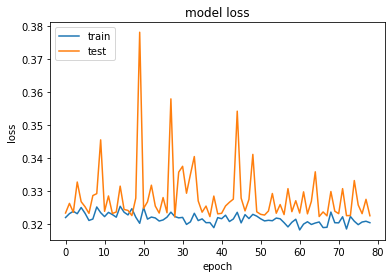

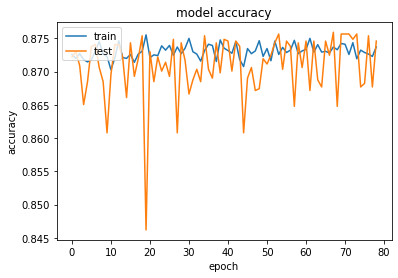

In [21]:
from matplotlib import pyplot as plt

#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
df_test.drop("uniqueid", axis =1, inplace = True)

In [23]:
testing = model.predict(df_test)

In [24]:
new_submission["bank_account"] = testing
new_submission

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,0.865784
1,uniqueid_6060 x Kenya,0.683252
2,uniqueid_6065 x Kenya,0.008824
3,uniqueid_6072 x Kenya,0.025275
4,uniqueid_6073 x Kenya,0.035072
...,...,...
10081,uniqueid_2998 x Uganda,0.013140
10082,uniqueid_2999 x Uganda,0.170628
10083,uniqueid_3000 x Uganda,0.298500
10084,uniqueid_3001 x Uganda,0.064576


In [25]:
for i in new_submission['bank_account']:
    if i > 0.5:
        new_submission['bank_account'] = new_submission['bank_account'].replace(i, 1)
    if i < 0.5:
        new_submission['bank_account'] = new_submission['bank_account'].replace(i, 0)

In [26]:
new_submission['bank_account'] = new_submission['bank_account'].astype('int32')

In [27]:
new_submission

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0
...,...,...
10081,uniqueid_2998 x Uganda,0
10082,uniqueid_2999 x Uganda,0
10083,uniqueid_3000 x Uganda,0
10084,uniqueid_3001 x Uganda,0


In [28]:
new_submission['bank_account'].value_counts()

0    9630
1     456
Name: bank_account, dtype: int64

In [29]:
new_submission.to_csv("deeplearning.csv", index = False)